# Evaluating Matchings Produced by Various Hyperparameters and Constraints

In [3]:
import time
import argparse
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

# Configuration
class Cfg:
    # Comment out the matchings you want to exclude. 
    matchings = [
        # 'assignments_all_reviewers_10_1.json',
        'assignments_all_reviewers_4.json',
        'assignments_max_4_5.json', 'assignments_q_0.75_4_5.json', 
    ]
    # 1.1 GB file
    scores_with_origin = 'scores_with_origin.csv'
    root_dir = './data/'
    reviewer_archive_dir = 'archives/'

def hr(): return display(HTML('<hr>'))

In [60]:
def load_matchings_file(matchings_path):
    with open(matchings_path, 'r') as file:
        matchings = json.load(file)
    return matchings

def to_matchings_df(matchings):
    """Returns a dataframe with schema {'paper_id': 'str', 'scores': List[float], 'reviewers': List[str]}"""
    records = []
    for paper_id in matchings:
        vals = matchings[paper_id]
        scores = [np.round(v['aggregate_score'], 3) for v in vals]
        reviewers = [v['user'] for v in vals]
        records.append({'paper_id': paper_id, 'scores': scores, 'reviewers': reviewers})
    return pd.DataFrame(records)
    
def get_quality_metrics(paper_id, reviewers_list, affinity_df):
    """
    Return a record of metrics to use for quality estimation.
    returns {'max_affinity': List[float], 'max_affinity_OR': List[float]}
    """
    ix_pid = affinity_df.index.get_level_values('paper_id')
    paper_affinity_df = affinity_df[ix_pid == paper_id]
    ix_rid = paper_affinity_df.index.get_level_values('reviewer_id')
    scores = {
        'max_affinities': [], 'max_affinity_papers': [], 
        'max_affinities_OR' : [], 'max_affinity_OR_papers': []
    }
    for reviewer_id in reviewers_list:
        ss =  paper_affinity_df[ix_rid == reviewer_id].reset_index()
        ss_or = ss[ss.origin == 'OR'].reset_index()
        
        max_affinity_id = ss.affinity_score.idxmax()
        max_affinity_or_id = ss_or.affinity_score.idxmax()
        print(max_affinity_id)
        max_affinity, max_affinity_paper = ss.loc[max_affinity_id].affinity_score, ss.loc[max_affinity_id].reviewers_paper_id
        max_affinity_or, max_affinity_or_paper = ss_or.loc[max_affinity_or_id].affinity_score, ss_or.loc[max_affinity_or_id].reviewers_paper_id 
        scores['max_affinities'].append(np.round(max_affinity, 3))
        scores['max_affinities_OR'].append(np.round(max_affinity_or, 3))
        scores['max_affinity_papers'].append(max_affinity_paper)
        scores['max_affinity_OR_papers'].append(max_affinity_or_paper)
    return scores
    
def to_load_df(matchings):
    """Returns a dataframe with schema {'reviewer_id': 'str', 'paper_ids': List[str], 'scores': List[str]}."""
    # reviewer_id -> [(paper_id, score), ...]
    reviewer_to_papers = {}
    for paper_id in matchings:
        for match in matchings[paper_id]:
            reviewer = match['user']
            score = np.round(match['aggregate_score'], 3)
            val = reviewer_to_papers.get(reviewer, [])
            val.append(paper_id)
            reviewer_to_papers[reviewer] = val
    df = pd.DataFrame({'reviewer_id': list(reviewer_to_papers.keys()),
                       'paper_info': list(reviewer_to_papers.values())})
    return df

In [61]:
# paper_id: [{'aggregate_score': float, 'user': str}, ...]
all_matchings = {fname: {'matchings': load_matchings_file(os.path.join(Cfg.root_dir, fname))} for fname in Cfg.matchings}

In [62]:
# csv_str = """
# zxdgDq9W0P7,~Aarshvi_Gajjar1,0.7630898952484131,other,fA85bseGskN
# zxdgDq9W0P7,~Aarshvi_Gajjar1,0.7710389494895935,OR,HdJpNjrvTF
# zxdgDq9W0P7,~Aarshvi_Gajjar1,0.6882244348526001,OR,Ej4YjxAvcp
# zLARft1nZR,~Aarshvi_Gajjar1,0.38991743326187134,other,fA85bseGskN
# zLARft1nZR,~Aarshvi_Gajjar1,0.28051409125328064,OR,HdJpNjrvTF
# zLARft1nZR,~Aarshvi_Gajjar1,0.4032236337661743,OR,Ej4YjxAvcp
# xaR1kD6BYY,~Aarshvi_Gajjar1,0.6529017686843872,other,fA85bseGskN
# xaR1kD6BYY,~Aarshvi_Gajjar1,0.5095101594924927,OR,HdJpNjrvTF
# xaR1kD6BYY,~Aarshvi_Gajjar1,0.501969575881958,OR,Ej4YjxAvcp
# """

# from io import StringIO

# affinity_df = pd.read_csv(StringIO(csv_str), header=None)
# affinity_df

,0,1,2,3,4
0,zxdgDq9W0P7,~Aarshvi_Gajjar1,0.763090,other,fA85bseGskN
1,zxdgDq9W0P7,~Aarshvi_Gajjar1,0.771039,OR,HdJpNjrvTF
2,zxdgDq9W0P7,~Aarshvi_Gajjar1,0.688224,OR,Ej4YjxAvcp
3,zLARft1nZR,~Aarshvi_Gajjar1,0.389917,other,fA85bseGskN
4,zLARft1nZR,~Aarshvi_Gajjar1,0.280514,OR,HdJpNjrvTF
5,zLARft1nZR,~Aarshvi_Gajjar1,0.403224,OR,Ej4YjxAvcp
6,xaR1kD6BYY,~Aarshvi_Gajjar1,0.652902,other,fA85bseGskN
7,xaR1kD6BYY,~Aarshvi_Gajjar1,0.509510,OR,HdJpNjrvTF
8,xaR1kD6BYY,~Aarshvi_Gajjar1,0.501970,OR,Ej4YjxAvcp


In [63]:
affinity_df = pd.read_csv(os.path.join(Cfg.root_dir, Cfg.scores_with_origin), header=None)
affinity_df.columns = ['paper_id', 'reviewer_id', 'affinity_score', 'origin', 'reviewers_paper_id']
affinity_df.set_index(['paper_id', 'reviewer_id'], inplace=True)
affinity_df.sort_index(inplace=True)
affinity_df.sample(4)

affinity_score origin reviewers_paper_id
paper_id    reviewer_id                                               
zxdgDq9W0P7 ~Aarshvi_Gajjar1        0.771039     OR         HdJpNjrvTF
zLARft1nZR  ~Aarshvi_Gajjar1        0.389917  other        fA85bseGskN
            ~Aarshvi_Gajjar1        0.280514     OR         HdJpNjrvTF
xaR1kD6BYY  ~Aarshvi_Gajjar1        0.509510     OR         HdJpNjrvTF

In [66]:
paper_id = 'zxdgDq9W0P7'
reviewers_id = ['~Aarshvi_Gajjar1']
print(get_quality_metrics(paper_id, reviewers_id, affinity_df))

1
{'max_affinities': [0.771], 'max_affinity_papers': ['HdJpNjrvTF'], 'max_affinities_OR': [0.771], 'max_affinity_OR_papers': ['HdJpNjrvTF']}


# General Max-affinity Score Statistics

- Mean score per paper and its standard deviation.
- Lowest 5% quantile score

In [6]:
for matching_name, info in all_matchings.items():
    matchings = info['matchings']
    mdf = to_matchings_df(matchings)
    mdf['quality_metrics'] = mdf.apply(lambda row: get_quality_metrics(row.paper_id, row.reviewers, affinity_df), axis=1)
    all_matchings[matching_name]['matchings_df'] = mdf

In [18]:
for matching_name, info in all_matchings.items():
    mdf = info['matchings_df']
    # Unpack
    mdf['max_affinities'] = mdf['quality_metrics'].apply(lambda x: x['max_affinities'])
    mdf['max_affinities_OR'] = mdf['quality_metrics'].apply(lambda x: x['max_affinities_OR'])
    # Compute mean
    mdf['mean(max_affinities)'] = mdf['max_affinities'].apply(lambda x: np.mean(x))
    mdf['mean(max_affinities_OR)'] = mdf['max_affinities_OR'].apply(lambda x: np.mean(x))
    mdf['mean_top2(max_affinities)'] = mdf['max_affinities'].apply(lambda x: np.mean(np.sort(x)[-2:]))
    mdf['mean_top2(max_affinities_OR)'] = mdf['max_affinities_OR'].apply(lambda x: np.mean(np.sort(x)[-2:]))
    mdf['std(max_affinities)'] = mdf['max_affinities'].apply(lambda x: np.std(x))
    mdf['std(max_affinities_OR)'] = mdf['max_affinities_OR'].apply(lambda x: np.std(x))
    mdf['n_reviewers'] = mdf['scores'].apply(lambda x: len(x))
    #display(mdf[['reviewers', 'max_affinities']].head(1))

Matchings: assignments_all_reviewers_4.json


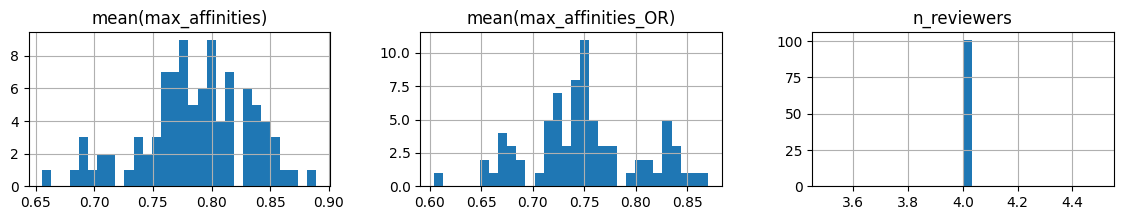

Matchings: assignments_max_4_5.json


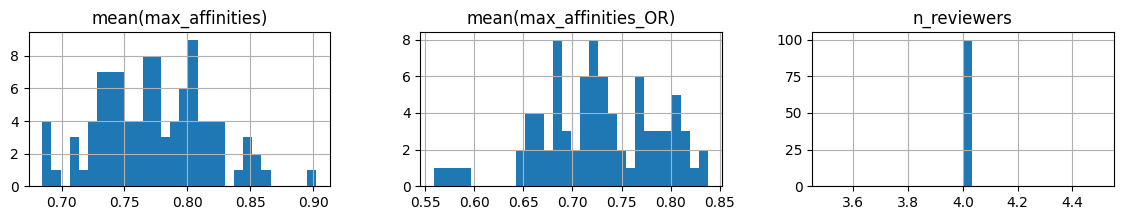

Matchings: assignments_q_0.75_4_5.json


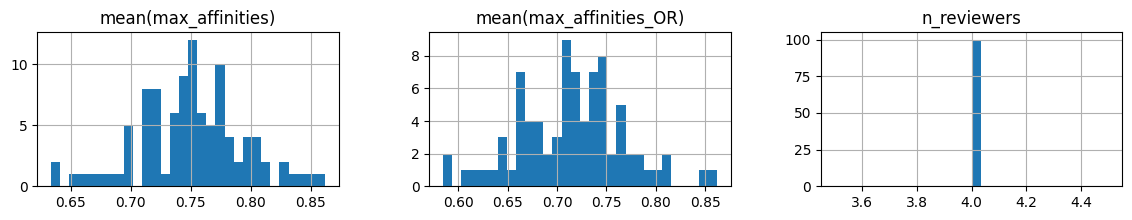

In [19]:
def plot_score_distr(df): 
    fig, axs = plt.subplots(1, 3, figsize=(14, 2))
    df.hist(column='mean(max_affinities)', bins=30, ax=axs[0])
    df.hist(column='mean(max_affinities_OR)', bins=30, ax=axs[1]);
    df.hist(column='n_reviewers', bins=30, ax=axs[2]);
    plt.show()

for matching_name, info in all_matchings.items():
    print("Matchings:", matching_name)
    sdf = info['matchings_df']
    plot_score_distr(sdf)
    hr()


In [10]:
def quantile_report(df, quantile, column='mean_paper_score'):
    lowq_mean_score = df[column].quantile(quantile)
    highq_mean_score = df[column].quantile(1-quantile)
    return lowq_mean_score, highq_mean_score


quantile = 0.05
records = []
score_col, std_col = 'mean(max_affinities)', 'std(max_affinities)'
for matching_name, info in all_matchings.items():
    scores_df = info['matchings_df']
    # display(scores_df.sample(3))
    low_score, high_score = quantile_report(scores_df, quantile, column=score_col)
    # Not strict inequalities;
    low_count = len(scores_df[scores_df[score_col] >= low_score])
    high_count = len(scores_df[scores_df[score_col] >= high_score])
    records.append({
        'matching_name': matching_name, 
        f'top {(quantile) * 100: .0f}% quantile score': high_score.round(2),
        f'top {(1 - quantile) * 100:.0f}% quantile score': low_score.round(2),
    })
print("Using evaluation score:", score_col)
display(pd.DataFrame(records))

hr()

quantile = 0.05
records = []
score_col, std_col = 'mean(max_affinities_OR)', 'std(max_affinities_OR)'
for matching_name, info in all_matchings.items():
    scores_df = info['matchings_df']
    # display(scores_df.sample(3))
    low_score, high_score = quantile_report(scores_df, quantile, column=score_col)
    # Not strict inequalities;
    low_count = len(scores_df[scores_df[score_col] >= low_score])
    high_count = len(scores_df[scores_df[score_col] >= high_score])
    records.append({
        'matching_name': matching_name, 
        f'top {(quantile) * 100: .0f}% quantile score': high_score.round(2),
        f'top {(1 - quantile) * 100:.0f}% quantile score': low_score.round(2),
    })
print("Using evaluation score:", score_col)
display(pd.DataFrame(records))


Using evaluation score: mean(max_affinities)


,matching_name,top 5% quantile score,top 95% quantile score
0,assignments_all_reviewers_4.json,0.85,0.70
1,assignments_max_4_5.json,0.85,0.71
2,assignments_q_0.75_4_5.json,0.83,0.68


Using evaluation score: mean(max_affinities_OR)


,matching_name,top 5% quantile score,top 95% quantile score
0,assignments_all_reviewers_4.json,0.84,0.67
1,assignments_max_4_5.json,0.81,0.64
2,assignments_q_0.75_4_5.json,0.80,0.62


# Inspect Tail Scores, Test and Flag Potential Outliers

For tail papers, check if
1. Flag one or more reviewers with a particularly low score for a given paper. Low defined with respect to mean score for the paper.
2. If there are no high-affinity reviewers for some papers, flag them.
3. ?

In [11]:
# Note: Manually selected looking at the distribution of std deviations.
score_list_col, score_col, std_col, max_std = 'max_affinities', 'mean(max_affinities)', 'std(max_affinities)', 0.10
display_cols = ['paper_id', 'reviewers', score_list_col, score_col, std_col, 'mean_top2(max_affinities)']
for matching_name, info in all_matchings.items():
    df = info['matchings_df']
    low_score, high_score = quantile_report(df, quantile, column=score_col)
    low_df = df[df[score_col] <= low_score]
    e_df = low_df[low_df[std_col] > max_std].copy()
    print(matching_name)
    # Are these papers low tail because some of the reviewrs have low scores?
    if len(e_df) == 0:
        print(f"\tTest 1: There are NO reviewers with lowscore (score <= mean(paper) - std, std: {max_std})")
    else:
        # 1-std away from mean. 
        print(f"\tTest 1: There are reviewers with low score (score <= mean(paper) - std, std: {max_std})")
        e_df['outlier_scores'] = e_df[score_list_col].apply(lambda scores: [x for x in scores if x < np.mean(scores) - max_std])
        display(e_df[display_cols + ['outlier_scores']])
    # Do all the reviewers have low score? Then the quality of overall reviews might be low.
    f_df = low_df[low_df[std_col] < max_std].copy()
    if len(f_df) > 0:
        print("\tTest 2: All the reviewers have low individual scores. " +
                  f"There are no 'high-affinity' reviewers. (std: {max_std})")
        display(f_df[display_cols])
    else:
        print("\tTest 2: There is at least one high affinity reviewer")
    hr()

assignments_all_reviewers_4.json
	Test 1: There are NO reviewers with lowscore (score <= mean(paper) - std, std: 0.1)
	Test 2: All the reviewers have low individual scores. There are no 'high-affinity' reviewers. (std: 0.1)


,paper_id,reviewers,max_affinities,mean(max_affinities),std(max_affinities)
21,CtFdaTTAwh,"[~Aaqib_Saeed1, ~Yixuan_Chen1, ~Zhuangdi_Zhu1,...","[0.826, 0.633, 0.579, 0.714]",0.68800,0.093040
25,G8zDeKOp0R,"[~Guangmo_Tong1, ~Karsten_Roth1, ~Runzhong_Wan...","[0.673, 0.78, 0.675, 0.648]",0.69400,0.050779
31,LUXMAeCeWs,"[~Alexandru_Tifrea1, ~Chengchao_Shen2, ~Yue_Su...","[0.732, 0.731, 0.705, 0.59]",0.68950,0.058457
39,Pjunw0i20t,"[~Apaar_Sadhwani1, ~Issam_H._Laradji1, ~Yang_L...","[0.521, 0.673, 0.742, 0.687]",0.65575,0.081962
85,sBRJXfjIYK,"[~Dmitrii_Marin2, ~Hwee_Kuan_Lee1, ~Riccardo_M...","[0.693, 0.668, 0.734, 0.648]",0.68575,0.032097


assignments_max_4_5.json
	Test 1: There are NO reviewers with lowscore (score <= mean(paper) - std, std: 0.1)
	Test 2: All the reviewers have low individual scores. There are no 'high-affinity' reviewers. (std: 0.1)


,paper_id,reviewers,max_affinities,mean(max_affinities),std(max_affinities)
10,8QJSTDII5d,"[~Chaitanya_Krishna_Joshi1, ~Phillip_Lippe1, ~...","[0.701, 0.671, 0.712, 0.655]",0.68475,0.022808
15,BJpmRDdA98,"[~Johannes_Fürnkranz1, ~Junghyun_Lee1, ~Magda_...","[0.77, 0.667, 0.692, 0.627]",0.68900,0.052197
41,Ri9Hgkvlys,"[~Baoyu_Jing1, ~Eldan_Cohen1, ~Shinichi_Shirak...","[0.754, 0.643, 0.721, 0.655]",0.69325,0.045959
75,kyWZXZ5ZHd,"[~Johannes_Fürnkranz1, ~Magda_Gregorova2, ~Par...","[0.691, 0.666, 0.665, 0.717]",0.68475,0.021335
94,x7zpwGCE5v,"[~Jihun_Hamm1, ~Ming_Li15, ~Mingxuan_Ju1, ~Yun...","[0.708, 0.743, 0.675, 0.63]",0.68900,0.041695


assignments_q_0.75_4_5.json
	Test 1: There are NO reviewers with lowscore (score <= mean(paper) - std, std: 0.1)
	Test 2: All the reviewers have low individual scores. There are no 'high-affinity' reviewers. (std: 0.1)


,paper_id,reviewers,max_affinities,mean(max_affinities),std(max_affinities)
10,8QJSTDII5d,"[~Parth_Kashyap_Thaker1, ~Sebastian_Mair1, ~Ta...","[0.569, 0.642, 0.705, 0.622]",0.63450,0.048665
15,BJpmRDdA98,"[~Antoine_Gourru1, ~Lanjun_Wang1, ~Marek_Elias...","[0.611, 0.68, 0.627, 0.617]",0.63375,0.027307
68,g8AigOTNXL,"[~Abdul_Fatir_Ansari2, ~Amrit_Bedi1, ~Shuangru...","[0.721, 0.667, 0.585, 0.647]",0.65500,0.048642
75,kyWZXZ5ZHd,"[~Haitao_Lin2, ~Hongying_Liu2, ~Magda_Gregorov...","[0.654, 0.707, 0.666, 0.641]",0.66700,0.024729
94,x7zpwGCE5v,"[~Baoyu_Jing1, ~Kun_He1, ~Sergey_Shuvaev1, ~Xu...","[0.649, 0.675, 0.628, 0.683]",0.65875,0.021753


# General Reviewer Load 

assignments_all_reviewers_4.json


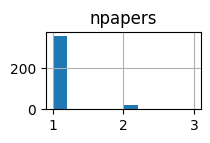

assignments_max_4_5.json


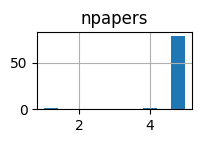

assignments_q_0.75_4_5.json


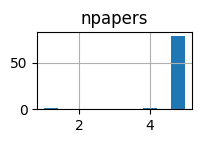

In [12]:
for matching_name, info in all_matchings.items():
    print(matching_name)
    matchings = info['matchings']
    load_df = to_load_df(matchings)
    load_df['npapers'] = load_df['paper_info'].apply(lambda x: len(x))
    load_df.hist(column='npapers', figsize=(2,1))
    info['load_df'] = load_df
    all_matchings[matching_name] = info
    plt.show()
    hr()

# Compare Changes in Matchings

Given two set of assigned reviewers (A, B) for a given `paper_id`, we can define
1. Set differences: $A-B$ and $B-A$
3. $\frac{A\cap B}{A\cup B}$

The some simple statistics can be computed to get a sense of how 'different' the two schemes are, such as;
1. % of papers where the matchings did not change; $A-B = B-A = 0$.
2. % of papers where the matchings completely changed $\frac{A\cap B}{A\cup B} = 0$.
3. For the papers where the matchings changed, how much did the corresponding mean-score change.
4. ?


In [13]:
import itertools

def unique_product(sets):
    result = set()
    for prod in itertools.product(sets, sets):
        result.add(tuple(sorted(prod)))
    return result

def compute_pairwise_stats(df_a, df_b, score_col):
    df_a = df_a.set_index('paper_id')
    df_b = df_b.set_index('paper_id')
    df_a.columns = [c + '_a' for c in df_a.columns]
    df_b.columns = [c + '_b' for c in df_b.columns]
    df_join = df_b.join(df_a)
    df_join['set_reviewers_b'] = df_join['reviewers_b'].apply(lambda x: set(x))
    df_join['set_reviewers_a'] = df_join['reviewers_a'].apply(lambda x: set(x))
    df_join['set_union_ab'] = df_join.apply(lambda x: x.set_reviewers_a.union(x.set_reviewers_b), axis=1)
    df_join['set_inter_ab'] = df_join.apply(lambda x: x.set_reviewers_a.intersection(x.set_reviewers_b), axis=1)
    df_join['len(a-b)'] = (df_join['set_reviewers_a'] - df_join['set_reviewers_b']).apply(lambda x: len(x))
    df_join['len(b-a)'] = (df_join['set_reviewers_b'] - df_join['set_reviewers_a']).apply(lambda x: len(x))
    df_join['inter/union'] = df_join.apply(lambda x: len(x.set_inter_ab) / len(x.set_union_ab), axis=1)
    df_join['mean_score_a-mean_score_b'] = df_join.apply(lambda x: x[score_col + '_a'] - x[score_col + '_b'], axis=1)
    df_join['mean_score_b-mean_score_a'] = df_join.apply(lambda x: x[score_col + '_b'] - x[score_col + '_a'], axis=1)
    return df_join[['len(a-b)', 'len(b-a)', 'inter/union', 'mean_score_b-mean_score_a', 'mean_score_a-mean_score_b']]
    
sources = list(all_matchings.keys())
source_pairs = unique_product(sources)

a = assignments_all_reviewers_4.json vs b = assignments_max_4_5.json Using evaluation score: mean(max_affinities)
Histogram of changes in assignments between A and B


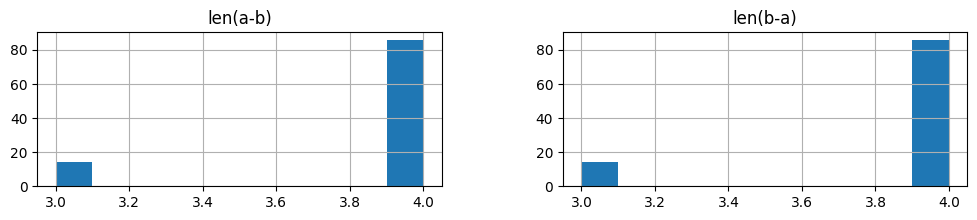

Boxplot of score change vs #changes in assignments


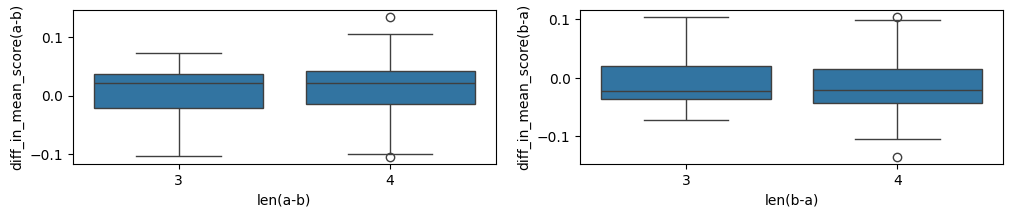

a = assignments_all_reviewers_4.json vs b = assignments_q_0.75_4_5.json Using evaluation score: mean(max_affinities)
Histogram of changes in assignments between A and B


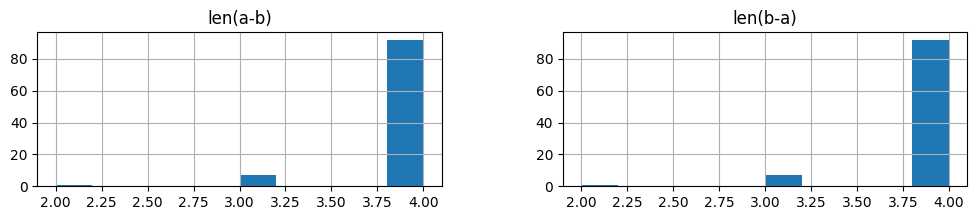

Boxplot of score change vs #changes in assignments


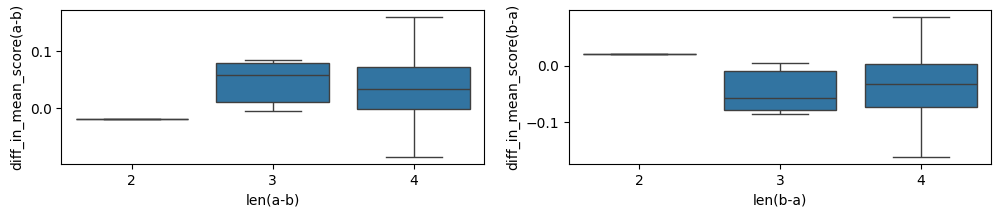

a = assignments_max_4_5.json vs b = assignments_q_0.75_4_5.json Using evaluation score: mean(max_affinities)
Histogram of changes in assignments between A and B


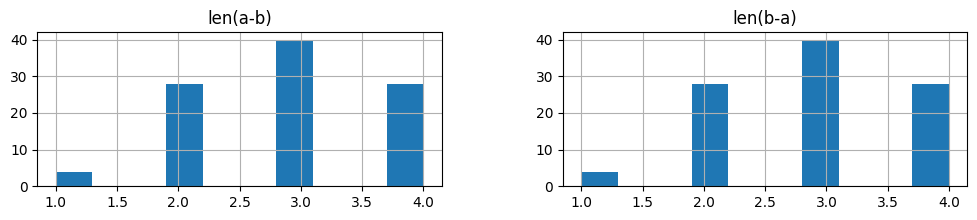

Boxplot of score change vs #changes in assignments


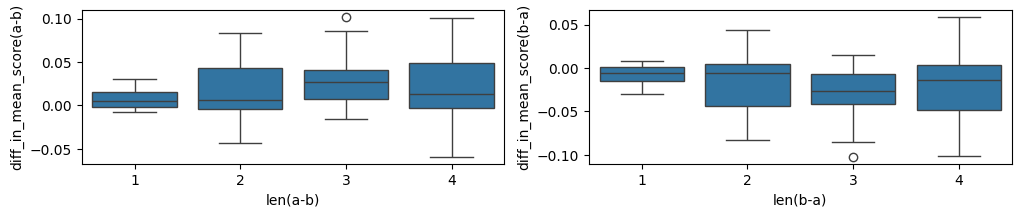

In [14]:
score_col = 'mean(max_affinities)'
for (key_a, key_b) in source_pairs:
    # Debugging
    if key_a == key_b: continue
        
    df_a, df_b = all_matchings[key_a]['matchings_df'].copy(), all_matchings[key_b]['matchings_df'].copy()
    print("a =", key_a, "vs", "b =", key_b, 'Using evaluation score:', score_col)
    stats = compute_pairwise_stats(df_a, df_b, score_col)
    # Visualize
    fig, axs = plt.subplots(1, 2, figsize=(12, 2))
    # If sizes of a and b are same, then these are identical
    stats.hist(column='len(a-b)', ax=axs[0])
    stats.hist(column='len(b-a)', ax=axs[1])
    print("Histogram of changes in assignments between A and B")
    #stats.hist(column='inter/union', ax=axs[2])
    plt.show()
    print("Boxplot of score change vs #changes in assignments")
    fig, axs = plt.subplots(1, 2, figsize=(12,2))
    # Note: Positive change means assignment under A was better
    sns.boxplot(data=stats, x='len(a-b)', y='mean_score_a-mean_score_b', ax=axs[0])
    axs[0].set_ylabel("diff_in_mean_score(a-b)")
    sns.boxplot(data=stats, x='len(b-a)', y='mean_score_b-mean_score_a', ax=axs[1])
    axs[1].set_ylabel("diff_in_mean_score(b-a)")
    plt.show()
    hr()
  

1. Most of the assignments seem to change when going from A to B. There are very few cases with 0-change.
2. When going from `a=assignments_max_4_5.json` to `b=assignments_q_0.75_4_5.json` (lower right plot) the score differences seem to be slightly worse on average.